# Lane finding on roads using traditional CV techniques
## Process overview
    1. Undistorted Image: Undistort the image using camera matrix and distortion co-efficients. 
    2. Binary Image: Convert the image to HLS space, threshold L (intensity) and S (color) and combine these to create a binary image
    3. Perpective Transformed Image: Transform the image to the birds eye view using perspective transform
    4. Lane Pixels: Get the pixels for left and right curves in the image by finding lane boundary
    5. Curvature: Fit the pixels corresponding to lanes to a second degree polynomial. Determine lane curvature, vehicle position w.r.t center of image. 
    6. Back to original view: transform bird eye view image to camera view image
    7. Visualization: Visualize pixels in the road boundary
    

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

#### Helper function to visualize multiple images

In [2]:
def visualize_images(input_images, num_cols, figure_name, cmap = None):
    "Shows input images by stacking them in num_cols columns"
    fig, axes = plt.subplots((int)((len(input_images) + 1) /num_cols), num_cols, figsize=(24, 20))

    fig = plt.gcf()
    fig.canvas.set_window_title(figure_name)
    
    print(figure_name)
    
    for ax, image in zip(axes.flat, input_images):
        if(image.shape[2]==1):
            ax.imshow(image[:,:,0], cmap = cmap)
        else:
            ax.imshow(image, cmap=cmap)

    plt.show()

#### Read and visualize the test images

Read 8 images from ../data/test_images/ folder
Image shape =  (720, 1280, 3)
input_images


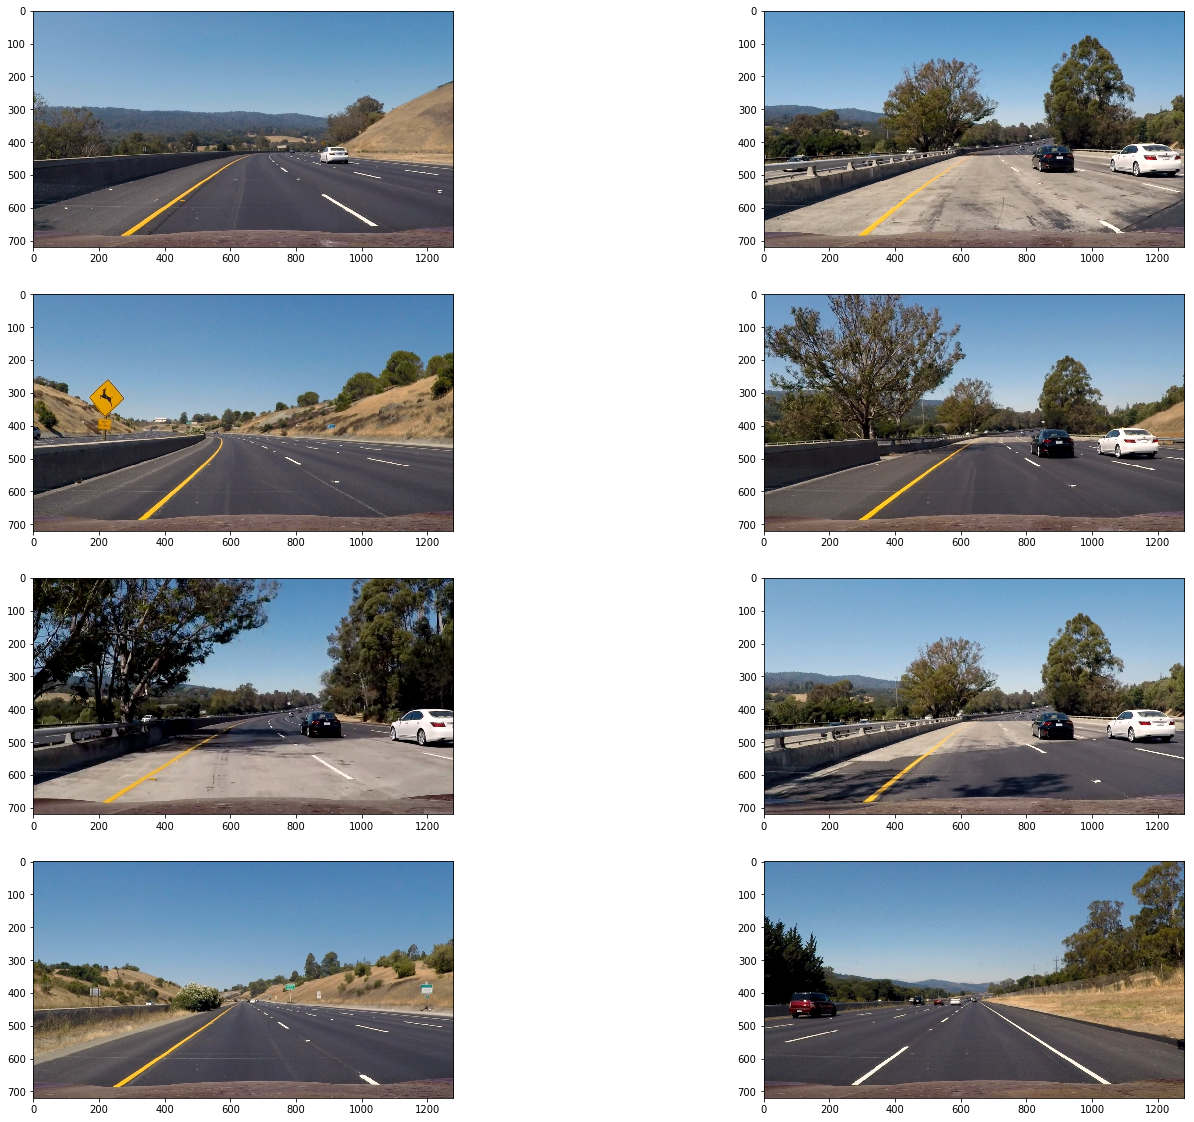

In [3]:
import glob

#path for the test imgaes
data_path = "../data/test_images/"

images_names = glob.glob(data_path + '*.jpg')

#List to store all input images
input_images = []

for idx, fname in enumerate(images_names):
    input_images.append(cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB))

print("Read %d images from %s folder" % (len(images_names), data_path))

image_shape = input_images[0].shape
print("Image shape = ", image_shape)
visualize_images(input_images, 2, "input_images")

## Step 1. Undistort all the read images
The code uses the camera matrix and distortion co-efficient from the pickle file
CameraCalibration.py file is used to create this pickle file

Undistorted images


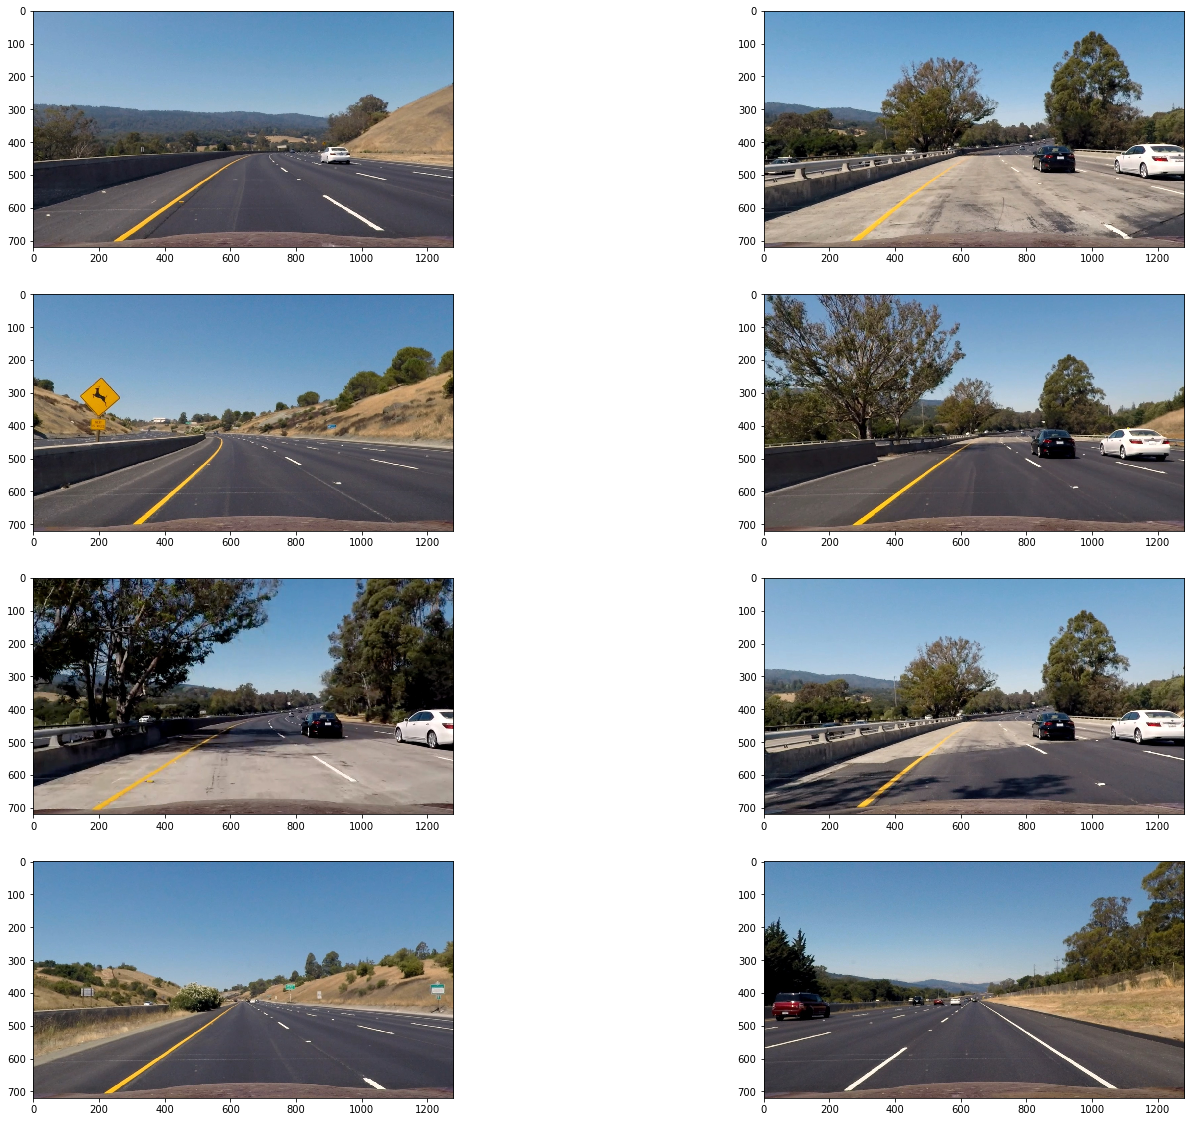

In [4]:
import pickle

# Path to Camera calibration pickle file
camera_cal_file = "../results/camera_cal/camera_dist_pickle.p"

# Read in the saved objpoints and imgpoints
cal_pickle = pickle.load( open(camera_cal_file, "rb" ) )
mtx = cal_pickle["mtx"]
dist = cal_pickle["dist"]

#Undistort all input images
undistorted_images = []
for image in input_images:
    undistorted_images.append(cv2.undistort(image, mtx, dist, None, mtx))

#Visualize undistorted images
visualize_images(undistorted_images, 2, "Undistorted images")

## Step 2. Get binary image
### Convert the image to HLS space, threshold L (intensity) and S (color) and combine these to create a binary image

color_binary_image is used only to help us visualize the results from thresholding

Result from black_binary_image is the result of this step

In [5]:
def color_binary_image(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    """
    Function takes is an RGB image, thresholds the images on lchannel (here we detect edges in x direction on intensity)
    and s channel (color). 
    Returns three channel image [zeros, lchannel_edges, color_threshold]. Dimension is same as the input image
    """
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary
    

In [6]:
def black_binary_image(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    """
    Function takes is an RGB image, thresholds the images on lchannel (here we detect edges in x direction on intensity)
    and s channel (color). 
    Returns one channel image [lchannel_edges | color_threshold] by combining both color and intersity results
    """
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    black_binary = np.zeros_like(s_channel)
    black_binary[(sxbinary > 0) | (s_binary > 0)] = 1
    black_binary = black_binary.reshape(img.shape[0], img.shape[1], 1) * 255
    return black_binary

Color binary images


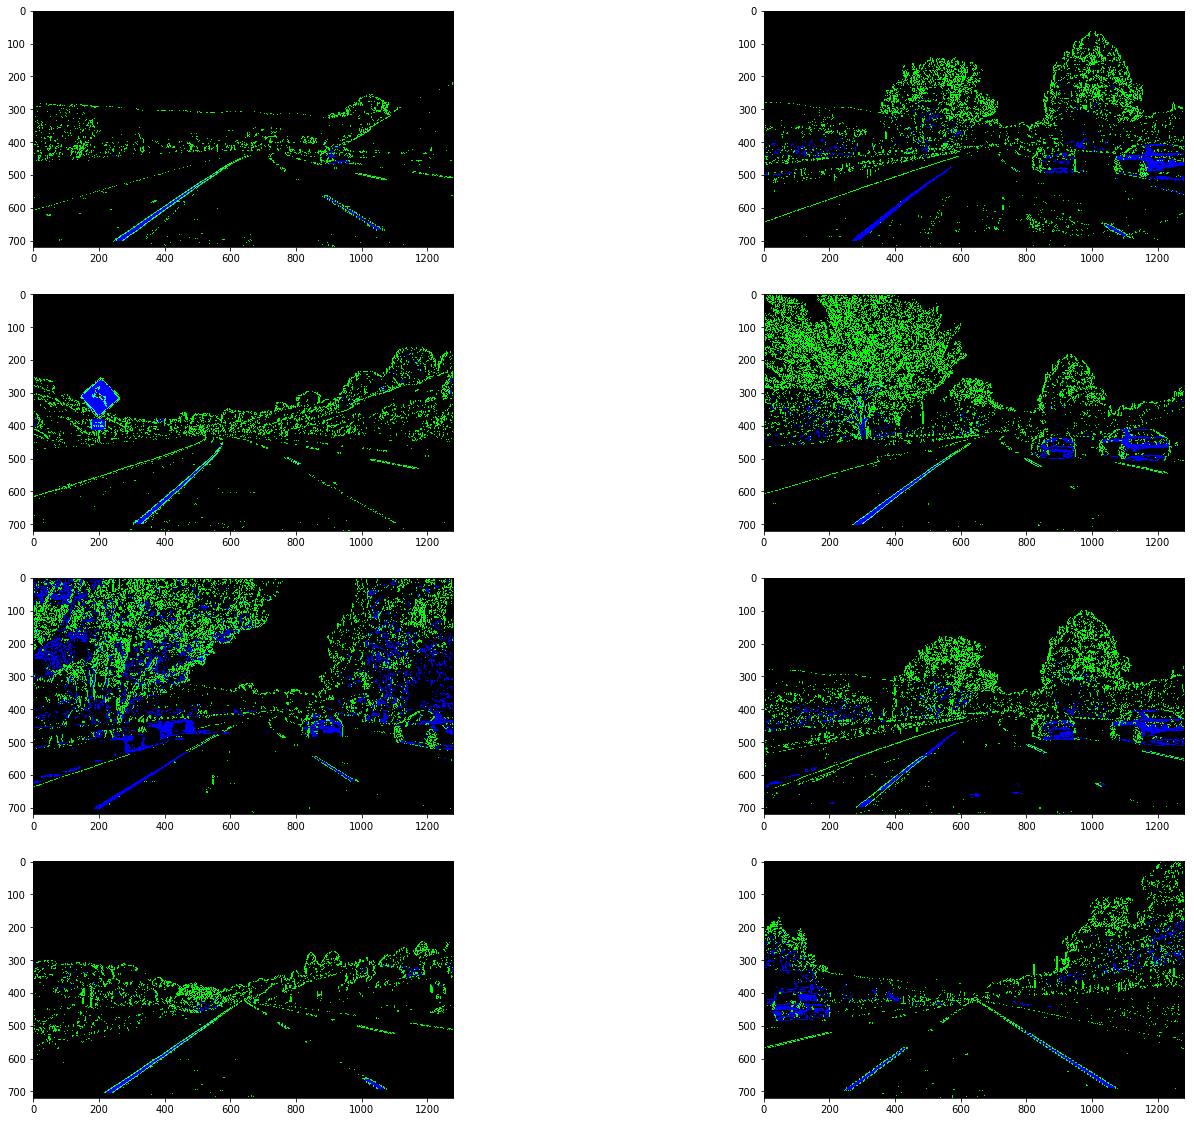

In [7]:
#Convert to color binary images and visualize

color_binary_images = np.zeros_like(undistorted_images)
for index, image in enumerate(undistorted_images):
    color_binary_images[index] = color_binary_image(image) 
    
#Vislualize color binary images    
visualize_images(color_binary_images, 2, "Color binary images")

Black binary images


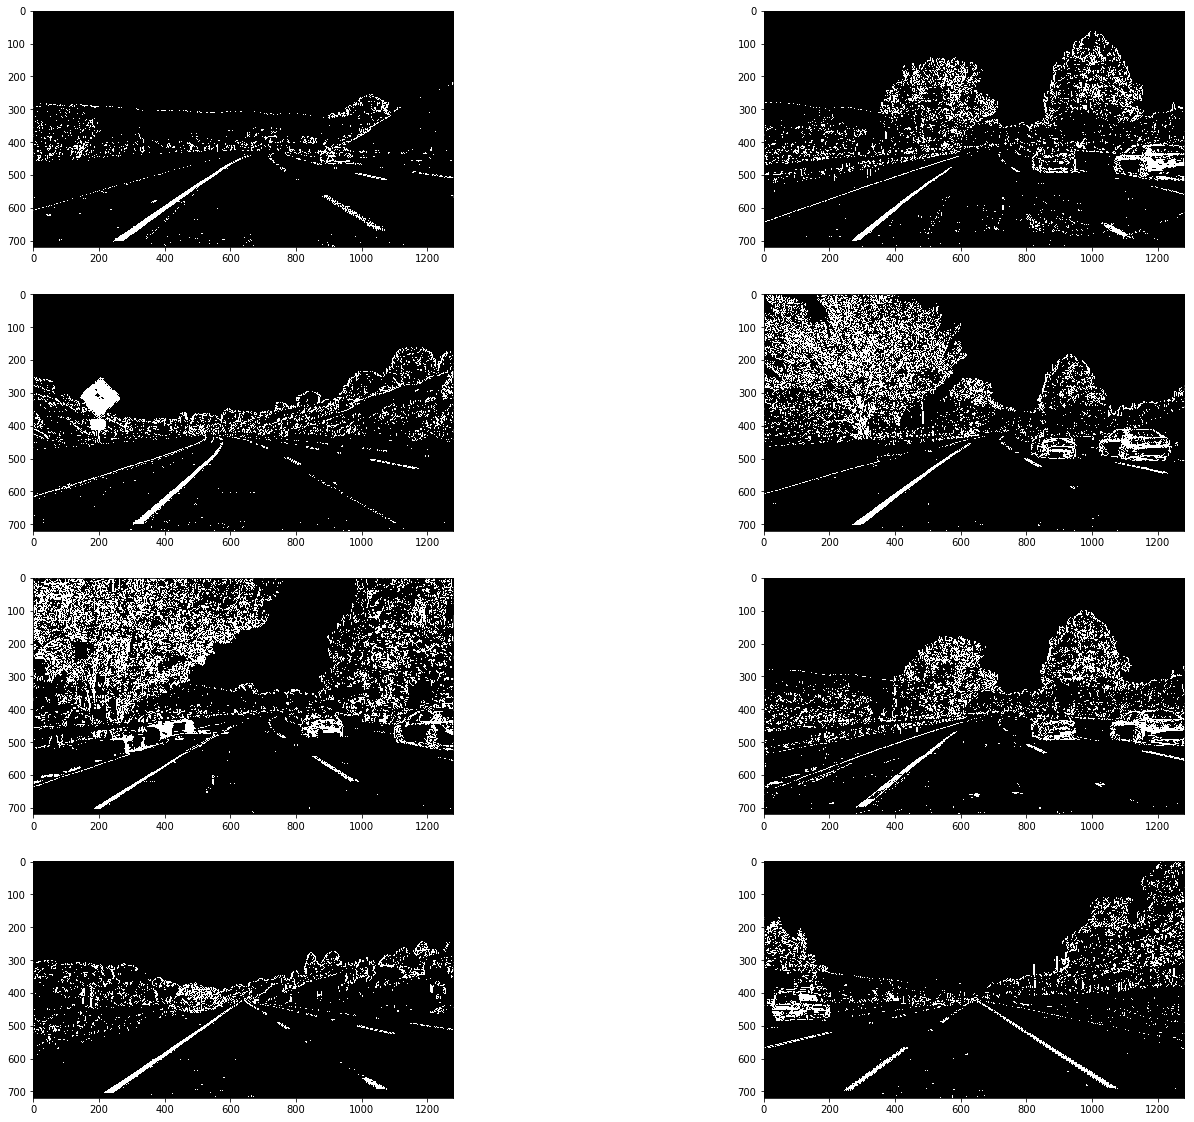

In [8]:
#Convert to black binary images and visualize
   
black_binary_images = np.zeros((len(undistorted_images), image_shape[0], image_shape[1], 1))

for index, image in enumerate(undistorted_images):
    black_binary_images[index] = black_binary_image(image) 

#Visualize black binary images
visualize_images(black_binary_images, 2, "Black binary images", cmap='Greys_r')

### Step 3. Perpective Transform
Transform the image to the birds eye view using perspective transform
1. Define source vertices (Take 4 points (2 on each lane) on the camera image which has straight lines). Here the image at last low and first column was used to define these points)
2. Define destination vertices (These line in src images appear to insersect when extrapolated but in dst images they should be parallel)
3. Transform the images using src and dst vertices

In [9]:
def perspective_transform(img, src_vertices, dst_vertices):
    """
    Funtion takes image, src and destination vertices and returns transformed image
    """
    M = cv2.getPerspectiveTransform(src_vertices, dst_vertices)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    return warped, M

In [10]:
#Define src and dst vertices 

src_vertices_roi = np.float32([(575, 460), (190 ,image_shape[0]), (1125, image_shape[0]), (710, 460)])
offset = 190
dst_vertices_roi = np.float32([[offset, 0], [offset, image_shape[0]], 
                                     [image_shape[1]-offset, image_shape[0]], 
                                     [image_shape[1]-offset, 0]])

src points on original image


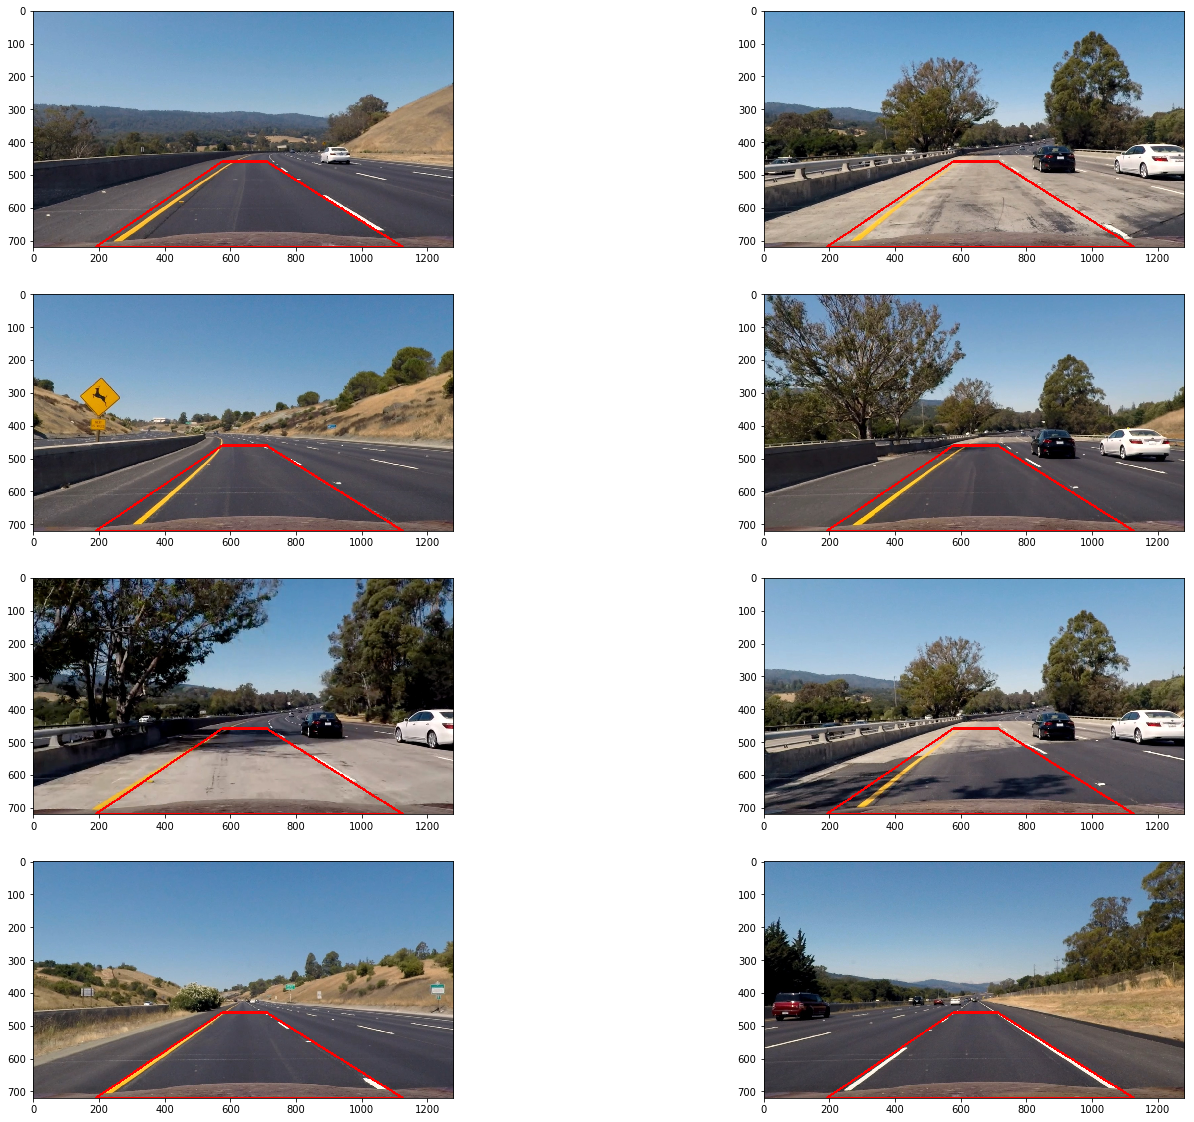

In [11]:
#Visualize source vertices on undistorted image

vis_roi = np.copy(undistorted_images)
for index, image in enumerate(vis_roi):
    cv2.polylines(image,[src_vertices_roi.reshape(-1,1,2).astype(int)], True,
                                   color = (255,0,0), thickness=5)
visualize_images(vis_roi, 2, "src points on original image")

perspective transformed color images


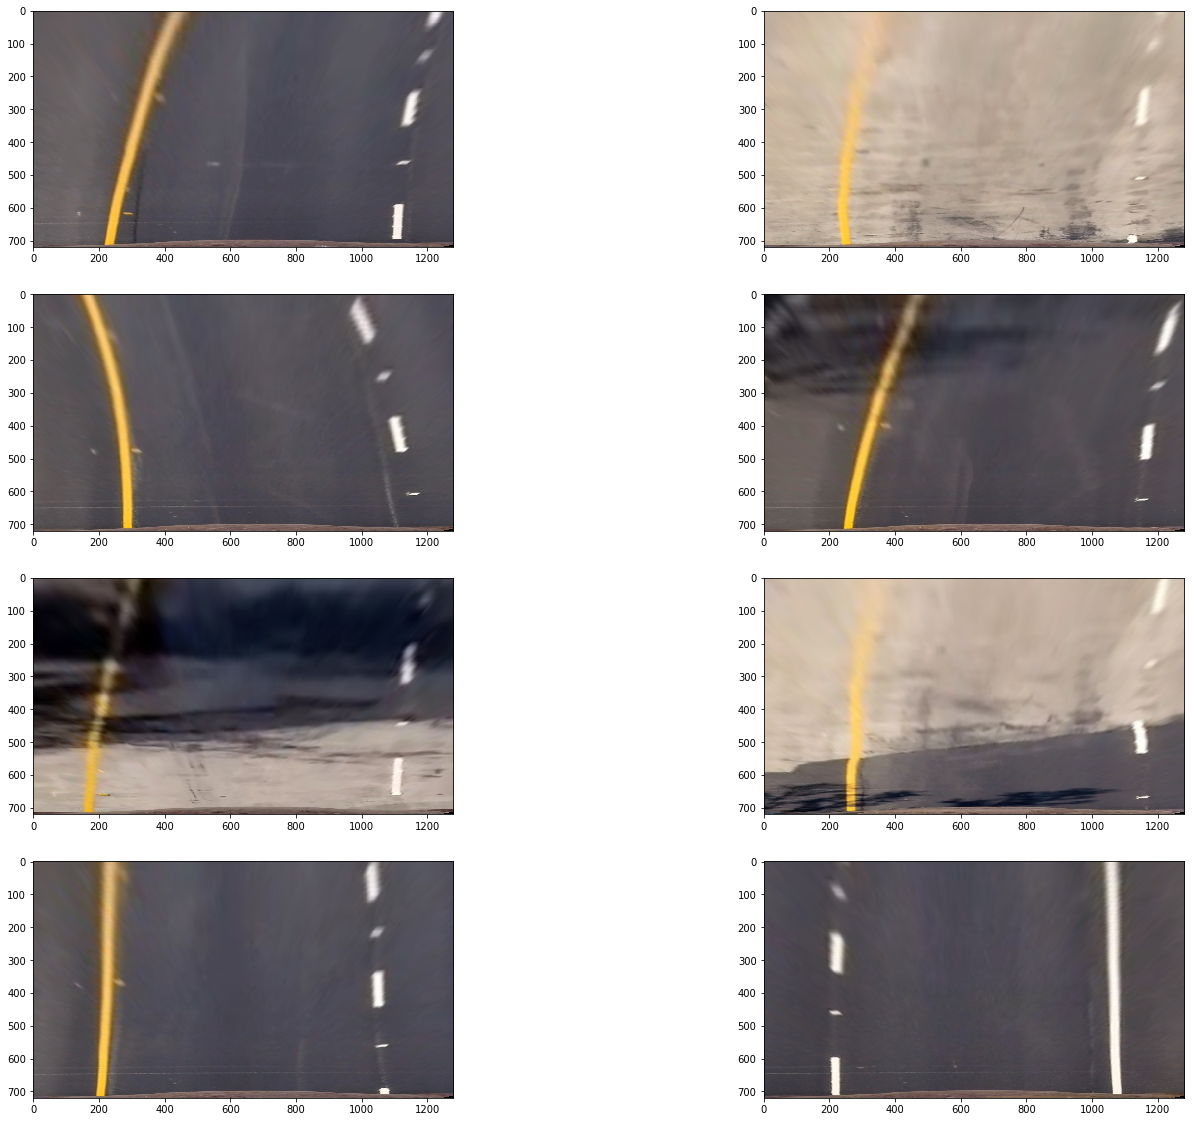

In [12]:
# Transform visualize transformation on undistorted color images
#We also need to save the transformation matrix to dewarp images again in the 

ptransformed_undist_images = np.zeros_like(undistorted_images)
ptransformed_M = []

for index, image in enumerate(undistorted_images):
    ptransformed_undist_images[index], perspective_M = perspective_transform(image, src_vertices_roi, dst_vertices_roi)
    ptransformed_M.append(perspective_M)
    
ptransformed_M = np.asarray(ptransformed_M)
    
visualize_images(ptransformed_undist_images, 2, "perspective transformed color images")

perspective transformed color binary images


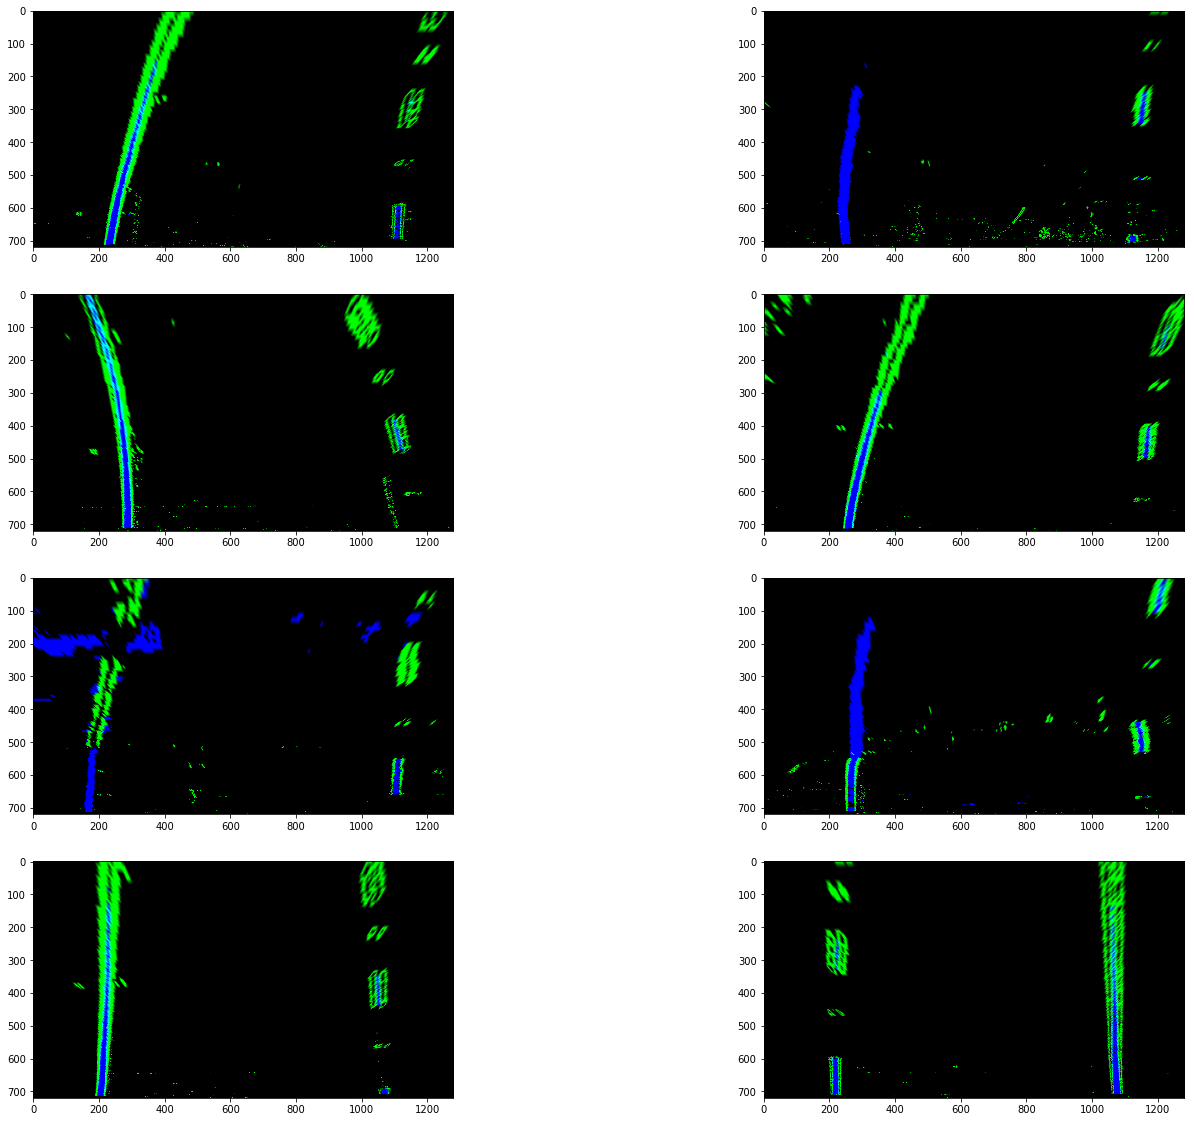

In [13]:
# Transform and visualize transformation on color binary images

ptransformed_color_binary_images = np.zeros_like(color_binary_images)

for index, image in enumerate(color_binary_images):
    ptransformed_color_binary_images[index], perspective_M = perspective_transform(image, src_vertices_roi, dst_vertices_roi)    

visualize_images(ptransformed_color_binary_images, 2, "perspective transformed color binary images")

perspective transformed black binary images


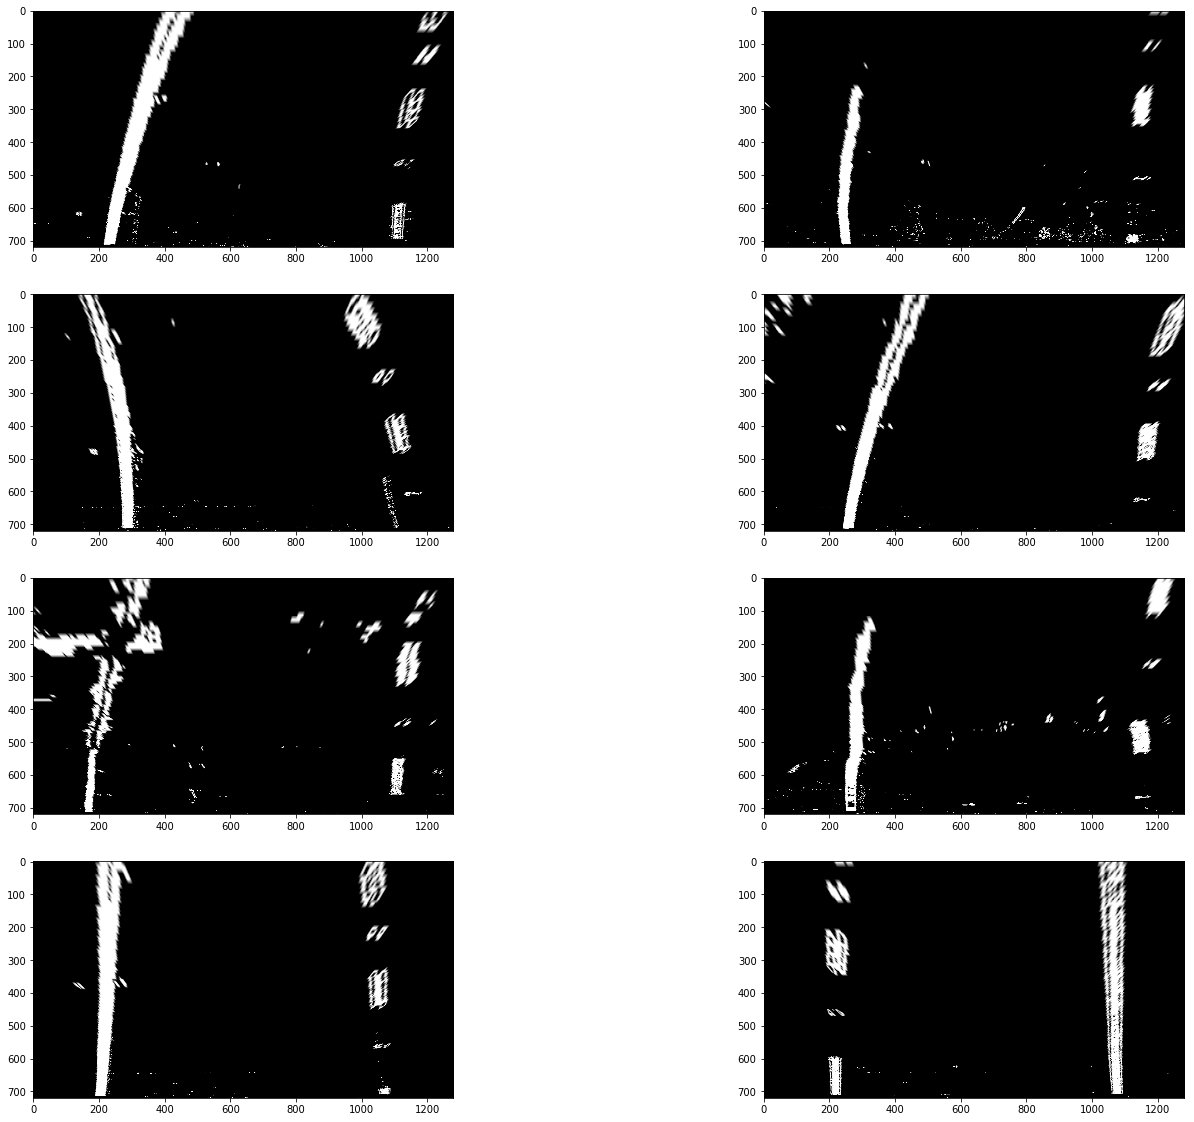

In [14]:
# Transform and visualize transformation on color binary images

ptransformed_black_binary_images = np.zeros_like(black_binary_images)

for index, image in enumerate(black_binary_images):
    ptransformed_black_binary_image, perspective_M = perspective_transform(image, src_vertices_roi, dst_vertices_roi)
    ptransformed_black_binary_image = ptransformed_black_binary_image.reshape(image_shape[0], image_shape[1], 1)
    ptransformed_black_binary_images[index] = ptransformed_black_binary_image
    
visualize_images(ptransformed_black_binary_images, 2, "perspective transformed black binary images", cmap='Greys_r')

## Step 4. Finding pixels associated with Lane boundaties
 Get the pixels for left and right curves in the image by finding lane boundary

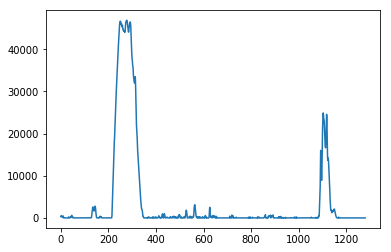

In [15]:
#Visualize historgram in bottom half of the image. See the peaks for left and right lane in the image
histogram = np.sum(ptransformed_black_binary_images[0][ptransformed_black_binary_images[0].shape[0]//2:,:], axis=0)
plt.plot(histogram)

#### Define functions to calculate window centroid, points on left lane and points on right lane

In [16]:
#define contants for the window used for the masks
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

In [17]:
def window_mask(width, height, img_ref, center,level):
    """
    The function returns a mask (rectangle with all values as '1') on the image. All other pixels in the image
    are 0 (black)
    """
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    """
    Function returns the centroids of the left and the right lane
    In addition it also returns the pixel locations of the left and right lane. These can be used
    to find the curvature of the lines by fitting them to a polynomial 
    """
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    #To get the left and right points
    l_points = np.zeros_like(image)
    r_points = np.zeros_like(image)
    l_mask = window_mask(window_width,window_height,image,l_center,0)
    r_mask = window_mask(window_width,window_height,image,r_center,0)
    l_points[(image == 1) & ((l_mask == 1) ) ] = 255
    r_points[(image == 1) & ((r_mask == 1) ) ] = 255
    left_x, left_y = l_points.nonzero()
    nonzero_left_indices = np.array([[left_x, left_y]])
    right_x, right_y = r_points.nonzero()
    nonzero_right_indices = np.array([[right_x, right_y]])
    
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
        #To get the left and right points
        l_mask = window_mask(window_width,window_height,image,l_center,level)
        r_mask = window_mask(window_width,window_height,image,r_center,level)
        l_points[(image == 1) & ((l_mask == 1) ) ] = 255
        r_points[(image == 1) & ((r_mask == 1) ) ] = 255
        left_x, left_y = l_points.nonzero()
        nonzero_left_indices = np.concatenate(np.array([[left_x, left_y]]), axis = 0)
        right_x, right_y = r_points.nonzero()
        nonzero_right_indices = np.concatenate(np.array([[right_x, right_y]]), axis = 0)

    return window_centroids, nonzero_left_indices, nonzero_right_indices

In [18]:
def visualize_window_centroids(image, window_centroids, window_width, window_height):
    """
    Helper function to visualize the centroids used to find lanes, It takes in the points for both 
    left and right lanes"""
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(image)
        r_points = np.zeros_like(image)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,image,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,image,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((image,image,image)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 0, template, 1, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((image,image,image)),np.uint8)
        
    return output


window centroids


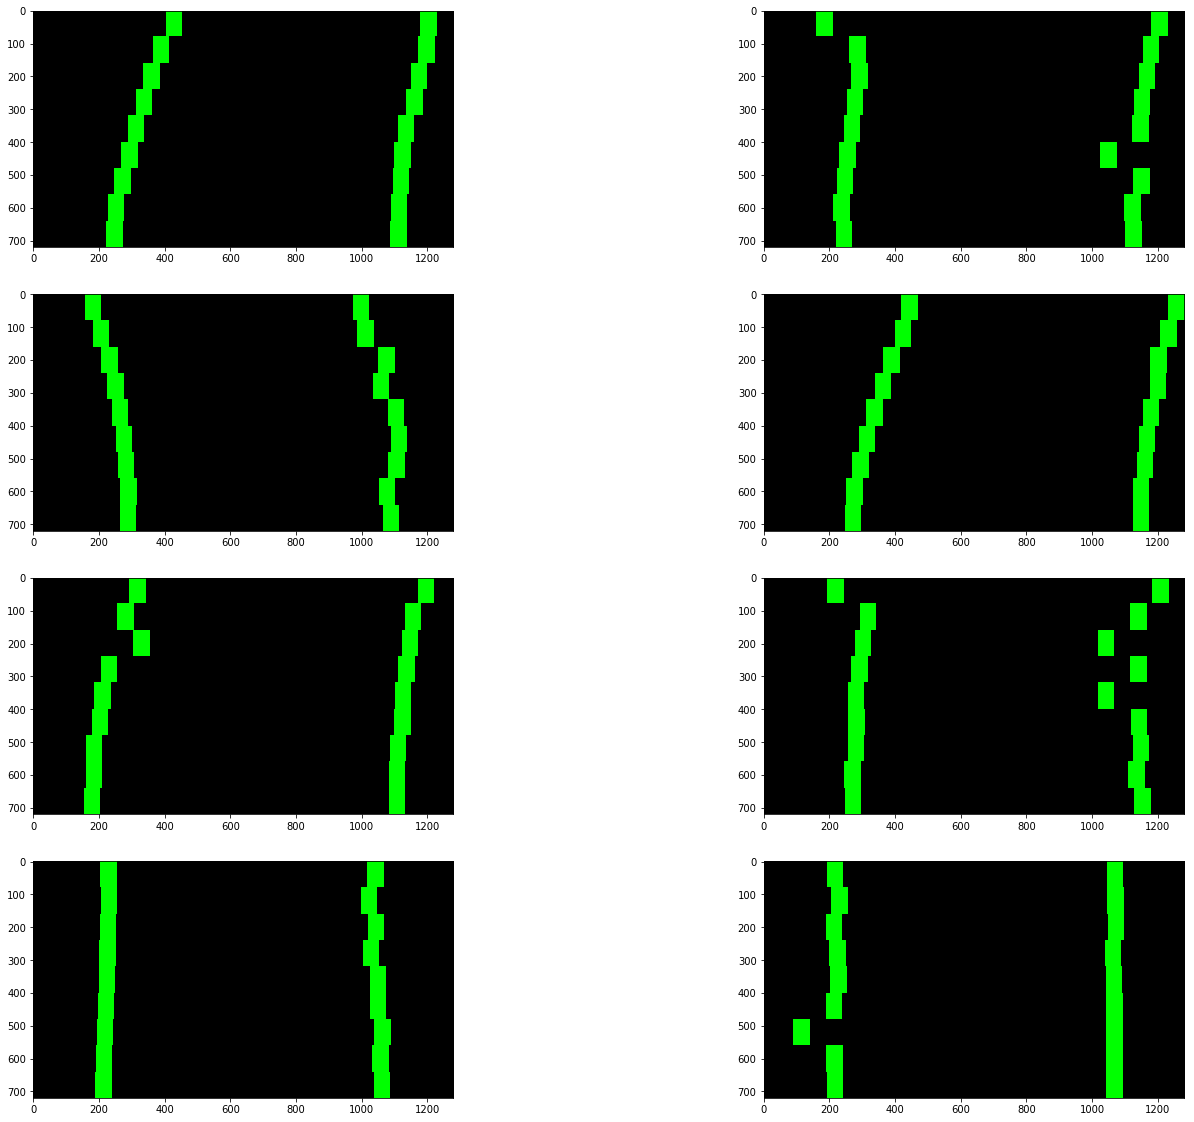

In [19]:
#Visualize the centroids

window_centroids_results = []
left_centroids_indices = []
right_centroids_indices = []
window_centroids_images = np.zeros_like(color_binary_images)
for index, image in enumerate(ptransformed_black_binary_images):
    window_centroids, left_points, right_points = find_window_centroids(image[:,:, 0]/255, window_width, window_height, margin)
    window_centroids_results.append(window_centroids)
    left_centroids_indices.append(left_points)
    right_centroids_indices.append(right_points)
    window_centroids_images[index] = visualize_window_centroids(image, window_centroids, window_width, window_height)

window_centroids_results = np.asarray(window_centroids_results)
visualize_images(window_centroids_images, 2, "window centroids")

## Step 5: Fit pixels to polymomial and calculate Curvature
Fit the pixels corresponding to lanes to a second degree polynomial. Determine lane curvature, vehicle position w.r.t center of image.

In [51]:
# Define a class to receive the characteristics of each line detection
import queue

class Line():
    def __init__(self, max_past = 5):
        #How many previous iterations to store
        self.n_iter = max_past
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = queue.Queue(self.n_iter) 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def line_from_pixels(self, points, ym_per_pix = 30/720, xm_per_pix = 3.7/700):
        """
        Function takes in points (with x and y coordinates) and converts that to a an object of the line class
        It has information about radius of curvature, all x detected pixels, all y detected pixels and more
        """

        #Get all x and y pixels
        self.allx = points[1]
        self.ally = points[0]

        #Fit pixels to the polynomial 
        self.current_fit = np.polyfit(self.ally, self.allx, 2)

        #Hack to add bottom of the image as well ( y = 0)
        self.allx = np.append(self.allx, self.current_fit[2])
        self.ally = np.append(self.ally, image_shape[0])

         #calculate curvature of the line
        self.radius_of_curvature = ((1 + (2*self.current_fit[0]*np.max(self.ally) + self.current_fit[1])**2)**1.5) / np.absolute(2*self.current_fit[0])

        # Fit new polynomials to x,y in world space
        fit_cr = np.polyfit(self.ally*ym_per_pix, self.ally*xm_per_pix, 2)

        # Calculate the new radii of curvature
        self.line_base_pos = ((1 + (2*fit_cr[0]*np.max(self.ally)*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
        
        x_curve = self.current_fit[0]*self.ally **2 + self.current_fit[1]*self.ally + self.current_fit[2]
        
        queue_size = self.recent_xfitted.qsize()
        if queue_size == self.n_iter:
            self.recent_xfitted.get()
        
        self.recent_xfitted.put(x_curve)
        
        if self.bestx == None:
            self.bestx = x_curve
        else:
            self.bestx = self.bestx * (queue_size-1)/queue_size + x_curve/queue_size
            
        if self.best_fit == None:
            self.best_fit = self.current_fit
        else:
            self.best_fit = self.best_fit * (queue_size-1)/queue_size + self.current_fit/queue_size

## Step 6 and 7: Visualization
Visualize our final results

In [52]:
from numpy.linalg import inv

def fill_pixels_road(image, M, left_line, right_line):
    """
    Functions takes in left line, right line and fill the region covered by these 2 curves, then warps it using inverse of matrix M. 
    Finally the this is added to the image passsed to the function
    """
    # Recast the x and y points into usable format for cv2.fillPoly()
    left_line_fitx = left_line.current_fit[0]*left_line.ally **2 + left_line.current_fit[1]*left_line.ally + left_line.current_fit[2]
    right_line_fitx = right_line.current_fit[0]*right_line.ally **2 + right_line.current_fit[1]*right_line.ally + right_line.current_fit[2]
    
    pts_left = np.array([np.transpose(np.vstack([left_line_fitx, left_line.ally]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line_fitx, right_line.ally])))])
    pts = np.hstack((pts_left, pts_right))
    
    color_warp = np.zeros_like(image).astype(np.uint8)
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inv(M), (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result

pixel segnmented images


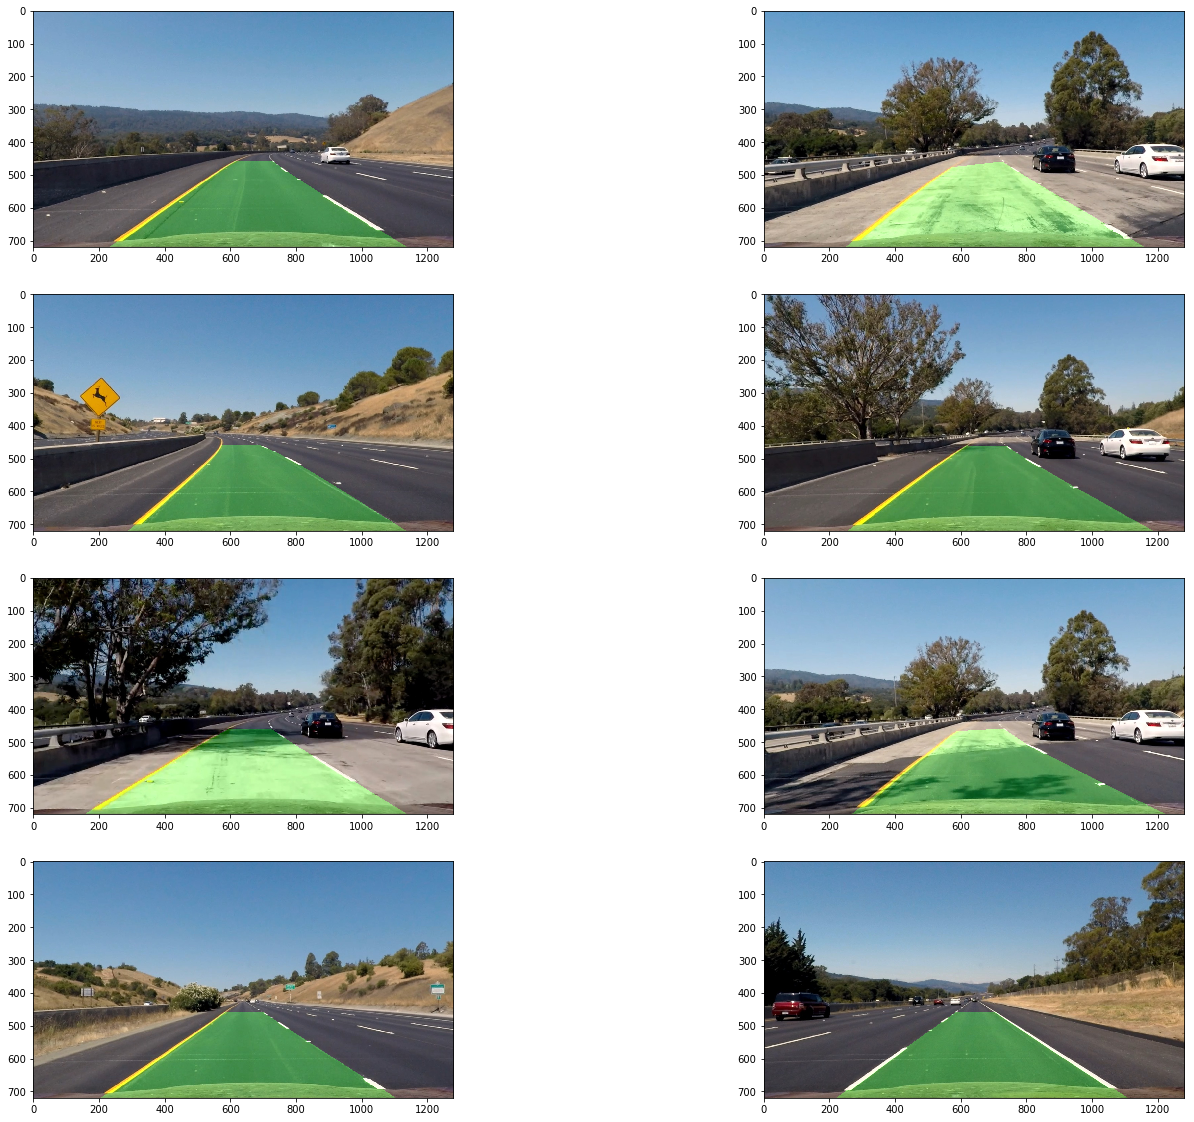

In [53]:
#Visualize pixel segmented images

pixel_segmented_images = []
for undistorted, left_points, right_points, M in zip (undistorted_images, left_centroids_indices, right_centroids_indices, ptransformed_M):
    left_line = Line()
    left_line.line_from_pixels(left_points)
    right_line = Line()
    right_line.line_from_pixels(right_points)
    pixel_segmented_images.append(fill_pixels_road(undistorted, M, left_line, right_line))
    
visualize_images(pixel_segmented_images, 2, "pixel segnmented images")

## Running Test on Video

In [54]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### find_lane function to take in image and run the pipeline for detecting lanes

In [61]:
def find_lanes(image):
    undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    black_binary = black_binary_image(undistorted)
    ptransformed_binary, M = perspective_transform(black_binary, src_vertices_roi, dst_vertices_roi)
    window_centroids, left_points, right_points = find_window_centroids(ptransformed_binary/255, window_width, window_height, margin)
    left_line = Line()  
    left_line.line_from_pixels(left_points)
    right_line = Line()
    right_line.line_from_pixels(right_points)
    result = fill_pixels_road(undistorted, M, left_line, right_line)
    return result

In [62]:
### Test Video 1

In [63]:
project_video_path = '../data/test_videos/project_video.mp4'
project_video_output = '../results/output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
project_video = VideoFileClip(project_video_path)
white_clip = project_video.fl_image(find_lanes) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ../results/output_videos/project_video.mp4
[MoviePy] Writing video ../results/output_videos/project_video.mp4


 10%|▉         | 122/1261 [00:30<04:55,  3.85it/s]

KeyboardInterrupt: 

In [ ]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format(project_video_output))

TODO:
    1. Calculate the curvature - Done
    2. Save the left and right line
    3. Sanity Check:
        Checking that they have similar curvature
        Checking that they are separated by approximately the right distance horizontally
        Checking that they are roughly parallel
    4. Add Y = 0 as the points in both the lines - Done
    5. Smoothing
    6. Use info from previous frames to search (optional)li
    7. Add y max of both to the curve